In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display


In [4]:
# Read data set from CSV file
data = pd.read_csv('BreadBasket_DMS.csv')
# Initial snapshot
display(data.head(5))

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


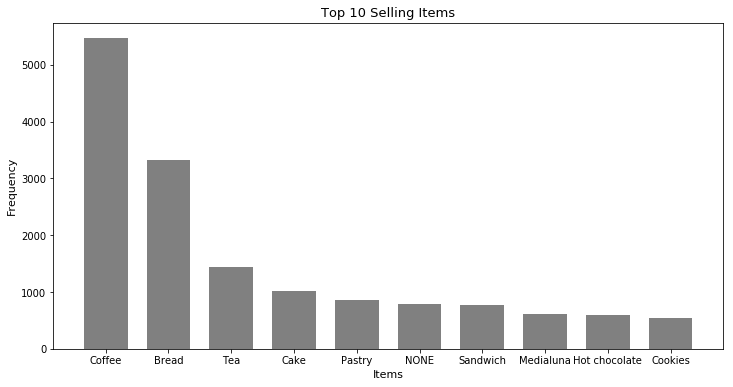

In [9]:
# see what the data actually looks like
items = data['Item'].value_counts().index
item_frequency = data['Item'].value_counts().values
plt.figure(figsize=(12,6))
plt.xlabel('Items', fontsize='11')
plt.ylabel('Frequency', fontsize='11')
plt.title('Top 10 Selling Items', fontsize='13')
plt.bar(items[:10],item_frequency[:10], width = 0.7, color="gray",linewidth=0.4)
plt.show()


In [10]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]




In [11]:
#### B. Association rules function ####
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item)


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item)


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders)

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [12]:
#Transforming original dataframe into the expected format: Series
orders_series = data.set_index('Transaction')['Item']
#Display series as dataframe for cosmetic purposes
display(pd.DataFrame(orders_series.head(5))) 

,Item
Transaction,
1,Bread
2,Scandinavian
2,Scandinavian
3,Hot chocolate
3,Jam


In [15]:
rules = association_rules(orders_series, 0.1)


Starting order_item:                  21293
Items with support >= 0.1:               4
Remaining order_item:                 11256
Remaining orders with 2+ items:        2753
Remaining order_item:                  6312
Item pairs:                              16
Item pairs with support >= 0.1:          5



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [17]:
#Show output sorted by lift
display(rules.head(5))

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
4,Coffee,Cake,545,0.197966,3124,1.134762,795,0.288776,0.174456,0.685535,0.604122
0,Coffee,Bread,678,0.246277,3124,1.134762,1495,0.543044,0.217029,0.453512,0.399654
1,Coffee,Tea,331,0.120232,3124,1.134762,898,0.326190,0.105954,0.368597,0.324823
3,Coffee,Coffee,1017,0.369415,3124,1.134762,3124,1.134762,0.325544,0.325544,0.286883
2,Bread,Coffee,403,0.146386,1495,0.543044,3124,1.134762,0.269565,0.129001,0.237552
